In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report
)
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


<h1 style="color: orange;">Paths</h1>

In [17]:
current_path = os.getcwd()
current_path = os.path.dirname(current_path)
ml_dir = os.path.join(current_path, "4-Machine-Learning")
model_dir = os.path.join(ml_dir, "Base-Model")
print("Data directory:", data_dir)
print("Model directory:", model_dir)

Data directory: /Users/isi.mube/Ironhack/Data-Curriculum/DSML-Master/Cosmic-Morphology/3-Train-Val-Test-Split
Model directory: /Users/isi.mube/Ironhack/Data-Curriculum/DSML-Master/Cosmic-Morphology/4-Machine-Learning/Base-Model


<h2 style="color: orange;">Data Loading</h2>

In [8]:
input_size = 224
batch_size = 64

In [9]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(int(input_size * 1.1)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:

image_datasets = {
    'test': datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=data_transforms['test']
    )
}
dataloaders = {
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=2)
}
class_names = image_datasets['test'].classes
print("Classes:", class_names)
print("Test dataset size:", len(image_datasets['test']))


Classes: ['asteroid', 'comet', 'galaxy', 'nebula', 'planet', 'star']
Test dataset size: 600


<h2 style="color: orange;">Evaluate</h2>

In [11]:
def evaluate_model(model, dataloaders, device, class_names):
    """
    Evaluate the given model on the test set and display metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    acc = np.mean(all_preds == all_labels)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    prec = precision_score(all_labels, all_preds, average='weighted')

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {"accuracy": acc, "f1_score": f1, "recall": rec, "precision": prec}

<h2 style="color: orange;">Base Model Evaluation</h2>

In [18]:
base_model_path = os.path.join(model_dir, "best_model.pth")
base_model = models.resnet50(weights=None)
num_ftrs = base_model.fc.in_features
base_model.fc = torch.nn.Linear(num_ftrs, len(class_names))
base_model.load_state_dict(torch.load(base_model_path))
base_model = base_model.to(device)
print("Base model loaded.")

Base model loaded.


/var/folders/7z/dp25t9yj1t7fql93jpgg11jm0000gn/T/ipykernel_41654/3016988109.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(base_mo


Evaluating Base Model...

Classification Report:
              precision    recall  f1-score   support

    asteroid       0.37      0.42      0.39       100
       comet       0.41      0.36      0.39       100
      galaxy       0.41      0.37      0.39       100
      nebula       0.65      0.68      0.66       100
      planet       0.46      0.51      0.48       100
        star       0.35      0.33      0.34       100

    accuracy                           0.45       600
   macro avg       0.44      0.45      0.44       600
weighted avg       0.44      0.45      0.44       600


Confusion Matrix:
[[42 14  8  6 17 13]
 [18 36  8  3 16 19]
 [14 10 37 15 11 13]
 [ 1  7 15 68  5  4]
 [18 13  5  1 51 12]
 [20  7 17 12 11 33]]


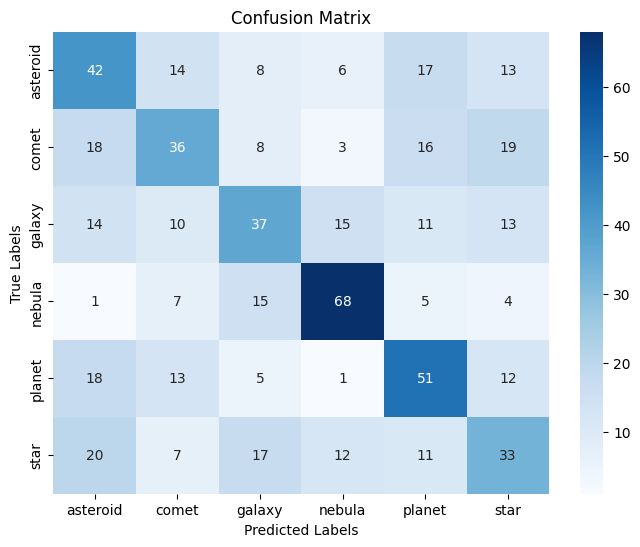

In [19]:
print("\nEvaluating Base Model...")
metrics_base = evaluate_model(base_model, dataloaders, device, class_names)

<h2 style="color: orange;">Fine-Tuned Model</h2>

In [20]:
fine_dir = os.path.join(ml_dir, "Fine-Tuned")

In [21]:
fine_tuned_model_path = os.path.join(fine_dir, "fine_tuned_model.pth")
fine_tuned_model = models.resnet50(weights=None)
fine_tuned_model.fc = torch.nn.Linear(num_ftrs, len(class_names))
fine_tuned_model.load_state_dict(torch.load(fine_tuned_model_path))
fine_tuned_model = fine_tuned_model.to(device)
print("Fine-tuned model loaded.")

Fine-tuned model loaded.


/var/folders/7z/dp25t9yj1t7fql93jpgg11jm0000gn/T/ipykernel_41654/3739222016.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fine_tuned_model.load_state_dict(torch.load(f


Evaluating Fine-Tuned Model...

Classification Report:
              precision    recall  f1-score   support

    asteroid       0.36      0.43      0.39       100
       comet       0.41      0.33      0.36       100
      galaxy       0.49      0.38      0.43       100
      nebula       0.65      0.73      0.69       100
      planet       0.42      0.50      0.46       100
        star       0.35      0.32      0.34       100

    accuracy                           0.45       600
   macro avg       0.45      0.45      0.44       600
weighted avg       0.45      0.45      0.44       600


Confusion Matrix:
[[43 12  4  9 17 15]
 [19 33  9  3 18 18]
 [13 15 38 14 12  8]
 [ 1  5 10 73  5  6]
 [24  7  6  1 50 12]
 [18  9 11 13 17 32]]


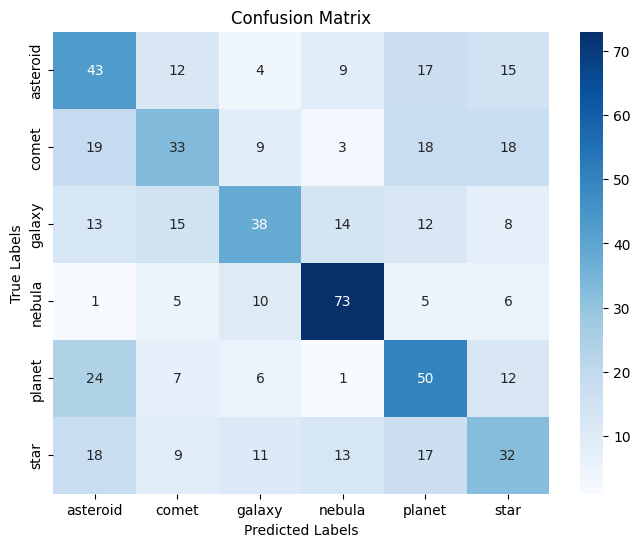

In [22]:
print("\nEvaluating Fine-Tuned Model...")
metrics_fine_tuned = evaluate_model(fine_tuned_model, dataloaders, device, class_names)